# Forecasting on a long horizon

Long-horizon forecasting refers to predictions far into the future, typically exceeding two seasonal periods. However, the exact definition of a 'long horizon' can vary based on the frequency of the data. For example, when dealing with hourly data, a forecast for three days into the future is considered long-horizon, as it covers 72 timestamps (calculated as 3 days × 24 hours/day). In the context of monthly data, a period exceeding two years would typically be classified as long-horizon forecasting. Similarly, for daily data, a forecast spanning more than two weeks falls into the long-horizon category.

Of course, forecasting over a long horizon comes with its challenges. The longer the forecast horizon, the greater the uncertainty in the predictions. It is also possible to have unknown factors come into play in the long-term that were not expected at the time of forecasting.

To tackle those challenges, use TimeGPT's specialized model for long-horizon forecasting by specifying `model='timegpt-1-long-horizon'` in your setup.

For a detailed step-by-step guide, follow this tutorial on long-horizon forecasting.

## 1. Import packages
First, we install and import the required packages and initialize the Nixtla client.

In [ ]:
#| hide
from nixtla.utils import colab_badge

In [ ]:
#| echo: false
colab_badge('docs/tutorials/04_longhorizon')

<img src='https://colab.research.google.com/assets/colab-badge.svg' ref='https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/04_longhorizon.ipynb' alt='Open this notebook in Google Colab'>

In [ ]:
#| hide
from dotenv import load_dotenv

In [ ]:
#| hide
load_dotenv()

True

In [ ]:
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

In [ ]:
#| hide
nixtla_client = NixtlaClient()

## 2. Load the data

Let's load the ETTh1 dataset. This is a widely used dataset to evaluate models on their long-horizon forecasting capabalities. 

The ETTh1 dataset monitors an electricity transformer from a region of a province of China including oil temperature and variants of load (such as high useful load and high useless load) from July 2016 to July 2018 at an hourly frequency.

For this tutorial, let's only consider the oil temperature variation over time.

In [ ]:
from datasetsforecast.long_horizon import LongHorizon

Y_df, *_ = LongHorizon.load(directory='./', group='ETTh1')

Y_df.head()

,unique_id,ds,y
0,OT,2016-07-01 00:00:00,1.460552
1,OT,2016-07-01 01:00:00,1.161527
2,OT,2016-07-01 02:00:00,1.161527
3,OT,2016-07-01 03:00:00,0.862611
4,OT,2016-07-01 04:00:00,0.525227


For this small experiment, let's set the horizon to 96 time steps (4 days into the future), and we will feed TimeGPT with a sequence of 42 days.

In [ ]:
test = Y_df[-96:]             # 96 = 4 days x 24h/day
input_seq = Y_df[-1104:-96]   # Gets a sequence of 1008 observations (1008 = 42 days * 24h/day)

## 3. Forecasting for long-horizon

Now, we are ready to use TimeGPT for long-horizon forecasting. Here, we need to set the `model` parameter to `"timegpt-1-long-horizon"`. This is the specialized model in TimeGPT that can handle such tasks.

In [ ]:
fcst_df = nixtla_client.forecast(
    df=input_seq,
    h=96,
    level=[90],
    finetune_steps=10,
    finetune_loss='mae',
    model='timegpt-1-long-horizon',
    time_col='ds',
    target_col='y'
)

INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Inferred freq: H
INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...


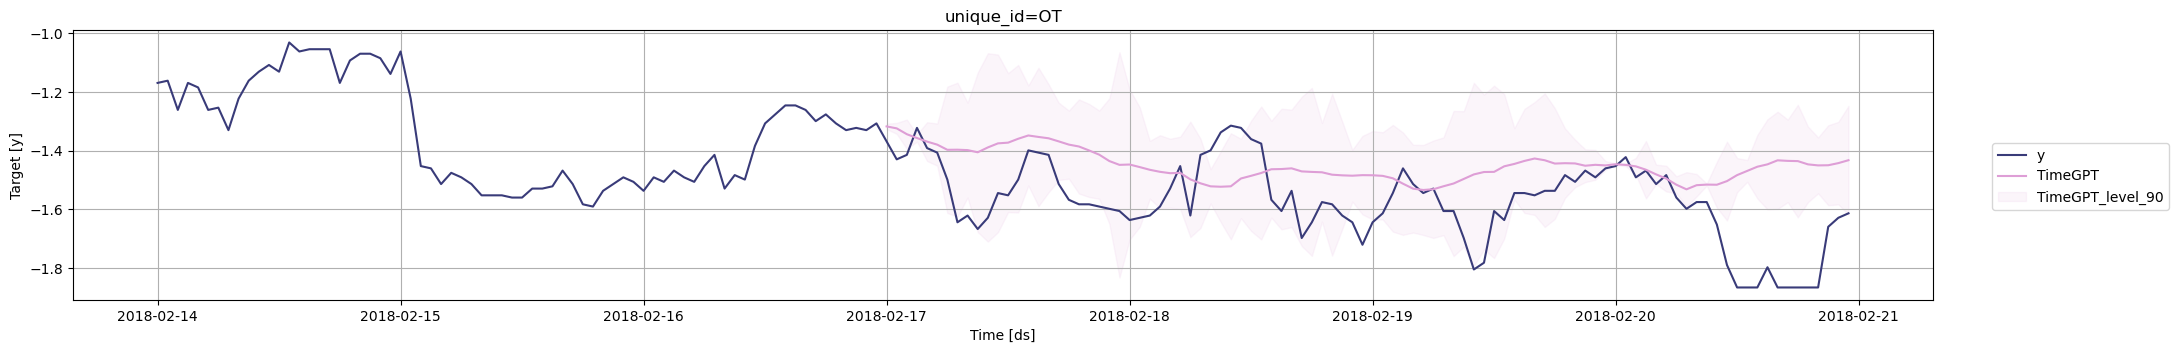

In [ ]:
nixtla_client.plot(Y_df[-168:], fcst_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')

## Evaluation

Let's now evaluate the performance of TimeGPT using the mean absolute error (MAE).

In [ ]:
test = test.copy()

test.loc[:, 'TimeGPT'] = fcst_df['TimeGPT'].values

In [ ]:
from utilsforecast.losses import mae

evaluation = mae(test, models=['TimeGPT'], id_col='unique_id', target_col='y')

print(evaluation)

  unique_id   TimeGPT
0        OT  0.146111


Here, TimeGPT achieves a MAE of 0.146.